# Evolution of Persona 1 within the two quarters¶

In [1]:
# Remove the warnings for presentation of the notebook. During the development, the warnings were not ignored.
import warnings
warnings.filterwarnings('ignore')

Some part of this calculation will use pyspark, namely the creation of the clickstream. So first, the pyspark and other dependent libraries must be imported and spark session must be inisiated.

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc =SparkContext()
spark = SparkSession(sc)

csQ4 = spark.read.format('csv').option('header', True).load('final-Q4.csv')
csQ1 = spark.read.format('csv').option('header', True).load('final-Q1.csv')
csQ4_pd = csQ4.toPandas()
csQ1_pd = csQ1.toPandas()

## Clickstream

Then, the below calculation is done to find each user session. More on this can be found on the technical paper. This specific line below will concate the type of activity and the page location of the user activities in Q4 as a result.

In [3]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *

windowSpec  = Window.partitionBy("userID").orderBy("timestamp")
dfQ4_1 = csQ4.withColumn("lagvalue", lag('timestamp', 1).over(windowSpec))
dfQ4_2 = dfQ4_1.withColumn('tsDiff', (unix_timestamp('timestamp') - unix_timestamp('lagvalue')))
dfQ4_3 = dfQ4_2.withColumn('tsDiff', when(col('tsDiff').isNull(), 0).otherwise(col('tsDiff')))
dfQ4_4 = dfQ4_3.withColumn('SessionNew', when(col('tsDiff') > 10800, 1).otherwise(0))
dfQ4_5 = dfQ4_4.withColumn('SessionName', concat(('userID'), lit('+Session-'), sum('SessionNew').over(windowSpec)))
dfQ4_6 = dfQ4_5.withColumn('pageActivity', concat(('activity'), lit('-'), ('page')))
dfQ4_6.show()

+-----+------+---------+-------+--------+-----+--------------------+-------------------+----+---+----+-------------------+-------+-------------------+------+----------+--------------+--------------------+
|  _c0|userID|companyID|country|activity|event|                page|          timestamp|hour|day|week|userCountPerCompany|cluster|           lagvalue|tsDiff|SessionNew|   SessionName|        pageActivity|
+-----+------+---------+-------+--------+-----+--------------------+-------------------+----+---+----+-------------------+-------+-------------------+------+----------+--------------+--------------------+
|65356|   125|       21| Turkey|    Page|  0.0|https://en.wikipe...|2020-10-01 03:37:57|   6|  3|   1|               1461|      0|               null|     0|         0| 125+Session-0|Page-https://en.w...|
|25702|   125|       21| Turkey|    Page|  0.0|https://en.wikipe...|2020-10-01 19:12:29|  22|  3|   1|               1461|      0|2020-10-01 03:37:57| 56072|         1| 125+Session

This specific line below will concate the type of activity and the page location of the user activities in Q1 as a result.

In [4]:
windowSpec1  = Window.partitionBy("userID").orderBy("timestamp")
dfQ1_1 = csQ1.withColumn("lagvalue", lag('timestamp', 1).over(windowSpec1))
dfQ1_2 = dfQ1_1.withColumn('tsDiff', (unix_timestamp('timestamp') - unix_timestamp('lagvalue')))
dfQ1_3 = dfQ1_2.withColumn('tsDiff', when(col('tsDiff').isNull(), 0).otherwise(col('tsDiff')))
dfQ1_4 = dfQ1_3.withColumn('SessionNew', when(col('tsDiff') > 10800, 1).otherwise(0))
dfQ1_5 = dfQ1_4.withColumn('SessionName', concat(('userID'), lit('+Session-'), sum('SessionNew').over(windowSpec1)))
dfQ1_6 = dfQ1_5.withColumn('pageActivity', concat(('activity'), lit('-'), ('page')))
dfQ1_6.show()

+-----+----------+------+---------+-------+--------+-----+-------------------+--------------------+----+---+----+-------------------+-------+-----------+-----------------------+-----------+-------------------+------+----------+-------------+--------------------+
|  _c0|Unnamed: 0|userID|companyID|country|activity|event|          timestamp|                page|hour|day|week|userCountPerCompany|cluster|predictions|Most common predictions|new cluster|           lagvalue|tsDiff|SessionNew|  SessionName|        pageActivity|
+-----+----------+------+---------+-------+--------+-----+-------------------+--------------------+----+---+----+-------------------+-------+-----------+-----------------------+-----------+-------------------+------+----------+-------------+--------------------+
|33263|     33263|   125|       21| Turkey|    Page|  0.0|2021-01-01 01:08:28|https://en.wikipe...|   4|  4|  14|               1516|      0|          0|                      0|          0|               null|  

In this iteration, we add one more concatenation in the column actDetail, showcasing the activity, page location and event name

In [5]:
dfQ4_7 = dfQ4_6.withColumn('actDetail', concat(('activity'), lit('-'), ('page'), lit('-'), ('event')))

dfQ1_7 = dfQ1_6.withColumn('actDetail', concat(('activity'), lit('-'), ('page'), lit('-'), ('event')))

Before turning them into clickstream, each dataframe is broken down further into each personas.

In [6]:
personaQ4_1_stream = dfQ4_7.filter(dfQ4_6['cluster'] == '0')
personaQ4_2_stream = dfQ4_7.filter(dfQ4_6['cluster'] == '1')
personaQ4_3_stream = dfQ4_7.filter(dfQ4_6['cluster'] == '2')
personaQ4_4_stream = dfQ4_7.filter(dfQ4_6['cluster'] == '3')
personaQ4_1_stream

DataFrame[_c0: string, userID: string, companyID: string, country: string, activity: string, event: string, page: string, timestamp: string, hour: string, day: string, week: string, userCountPerCompany: string, cluster: string, lagvalue: string, tsDiff: bigint, SessionNew: int, SessionName: string, pageActivity: string, actDetail: string]

In [7]:
personaQ1_1_stream = dfQ1_7.filter(dfQ1_6['new cluster'] == '0')
personaQ1_2_stream = dfQ1_7.filter(dfQ1_6['new cluster'] == '1')
personaQ1_3_stream = dfQ1_7.filter(dfQ1_6['new cluster'] == '2')
personaQ1_4_stream = dfQ1_7.filter(dfQ1_6['new cluster'] == '3')
personaQ1_1_stream

DataFrame[_c0: string, Unnamed: 0: string, userID: string, companyID: string, country: string, activity: string, event: string, timestamp: string, page: string, hour: string, day: string, week: string, userCountPerCompany: string, cluster: string, predictions: string, Most common predictions: string, new cluster: string, lagvalue: string, tsDiff: bigint, SessionNew: int, SessionName: string, pageActivity: string, actDetail: string]

Now, pyspark is used to process the clickstream of Q4 using group by and aggregate function. There are 4 types of clickstream created. Combination of page and activity, just the page, just the activity, and combination of activity, page and the event name. Then, the count of activity per page was calculated as well. 
<br><br>
<b style="color: red">From this calculation on until the end of the section, the calculation is only for the first persona. Notice the _1 in the variable name</b>

In [8]:
import pyspark.sql.functions as f
import pandas as pd

dfPQ4_1 = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.pageActivity)))
dfPQ4_1 = dfPQ4_1.groupby('concat_ws(> , collect_list(pageActivity))').count()
dfPQ4_1 = dfPQ4_1.sort(col('count').desc())
dfPQ4_1 = dfPQ4_1.toPandas()

dfPQ4_1a = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.page)))
dfPQ4_1a = dfPQ4_1a.groupby('concat_ws(> , collect_list(page))').count()
dfPQ4_1a = dfPQ4_1a.sort(col('count').desc())
dfPQ4_1a = dfPQ4_1a.toPandas()

dfPQ4_1b = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.activity)))
dfPQ4_1b = dfPQ4_1b.groupby('concat_ws(> , collect_list(activity))').count()
dfPQ4_1b = dfPQ4_1b.sort(col('count').desc())
dfPQ4_1b = dfPQ4_1b.toPandas()

dfPQ4_1c = personaQ4_1_stream[personaQ4_1_stream['activity'] == 'Event']
dfPQ4_1c = dfPQ4_1c.groupby('page').count()
dfPQ4_1c = dfPQ4_1c.toPandas()

dfPQ4_1d = personaQ4_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ4_1_stream.actDetail)))
dfPQ4_1d = dfPQ4_1d.groupby('concat_ws(> , collect_list(actDetail))').count()
dfPQ4_1d = dfPQ4_1d.sort(col('count').desc())
dfPQ4_1d = dfPQ4_1d.toPandas()

The below algorithms are the same as above, but using Q1 dataframe.

In [9]:
dfPQ1_1 = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.pageActivity)))
dfPQ1_1 = dfPQ1_1.groupby('concat_ws(> , collect_list(pageActivity))').count()
dfPQ1_1 = dfPQ1_1.sort(col('count').desc())
dfPQ1_1 = dfPQ1_1.toPandas()

dfPQ1_1a = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.page)))
dfPQ1_1a = dfPQ1_1a.groupby('concat_ws(> , collect_list(page))').count()
dfPQ1_1a = dfPQ1_1a.sort(col('count').desc())
dfPQ1_1a = dfPQ1_1a.toPandas()

dfPQ1_1b = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.activity)))
dfPQ1_1b = dfPQ1_1b.groupby('concat_ws(> , collect_list(activity))').count()
dfPQ1_1b = dfPQ1_1b.sort(col('count').desc())
dfPQ1_1b = dfPQ1_1b.toPandas()

dfPQ1_1c = personaQ1_1_stream[personaQ1_1_stream['activity'] == 'Event']
dfPQ1_1c = dfPQ1_1c.groupby('page').count()
dfPQ1_1c = dfPQ1_1c.toPandas()

dfPQ1_1d = personaQ1_1_stream.groupby('SessionName').agg(f.concat_ws('> ', f.collect_list(personaQ1_1_stream.actDetail)))
dfPQ1_1d = dfPQ1_1d.groupby('concat_ws(> , collect_list(actDetail))').count()
dfPQ1_1d = dfPQ1_1d.sort(col('count').desc())
dfPQ1_1d = dfPQ1_1d.toPandas()
dfPQ1_1d

,"concat_ws(> , collect_list(actDetail))",count
0,Page-https://en.wikipedia.org/wiki/Bookkeeping...,1001
1,Page-https://en.wikipedia.org/wiki/Main_Page-0.0,988
2,Page-https://en.wikipedia.org/wiki/Accounting-0.0,973
3,Page-https://en.wikipedia.org/wiki/Financial_t...,970
4,Page-https://en.wikipedia.org-0.0,944
...,...,...
6063,Page-https://en.wikipedia.org/wiki/Bookkeeping...,1
6064,Page-https://en.wikipedia.org/wiki/Bookkeeping...,1
6065,Event-https://en.wikipedia.org/wiki/Accounting...,1
6066,Event-https://en.wikipedia.org/wiki/Bookkeepin...,1


## Persona group size
The below cell calculates the magnitude of each persona both in number and in percentage. Then, it calculates the difference from Q4 to Q1. In the iteration 2, the amount shown was not the amount of users but user activity and thus fixed in this iteration.

In [10]:
import numpy as np

cardinality_df_Q4 = csQ1_pd.drop_duplicates(subset=['userID'])
cardinality_df_Q4 = pd.DataFrame(cardinality_df_Q4['cluster'].value_counts().reset_index())
cardinality_df_Q4.rename(columns={
    'index': 'Persona',
    'cluster': 'Magnitude_Q4'
}, inplace=True)
cardinality_df_Q4['MagnitudeInPercentage_Q4'] = cardinality_df_Q4['Magnitude_Q4'] /cardinality_df_Q4['Magnitude_Q4'].sum() * 100
cardinality_df_Q4['MagnitudeInPercentage_Q4'] = np.ceil(cardinality_df_Q4['MagnitudeInPercentage_Q4'])
cardinality_df_Q4

cardinality_df_Q1 = csQ1_pd.drop_duplicates(subset=['userID'])
cardinality_df_Q1 = pd.DataFrame(cardinality_df_Q1['new cluster'].value_counts().reset_index())

cardinality_df_Q1.rename(columns={
    'index': 'Persona',
    'new cluster': 'Magnitude_Q1'
}, inplace=True)
cardinality_df_Q1['MagnitudeInPercentage_Q1'] = cardinality_df_Q1['Magnitude_Q1'] /cardinality_df_Q1['Magnitude_Q1'].sum() * 100
cardinality_df_Q1['MagnitudeInPercentage_Q1'] = np.ceil(cardinality_df_Q1['MagnitudeInPercentage_Q1'])
cardinality_df_Q1

,Persona,Magnitude_Q1,MagnitudeInPercentage_Q1
0,0,96,48.0
1,3,63,32.0
2,1,32,16.0
3,2,10,5.0


In [11]:
size = cardinality_df_Q1.merge(cardinality_df_Q4, on='Persona')
size.head()

,Persona,Magnitude_Q1,MagnitudeInPercentage_Q1,Magnitude_Q4,MagnitudeInPercentage_Q4
0,0,96,48.0,96,48.0
1,3,63,32.0,63,32.0
2,1,32,16.0,32,16.0
3,2,10,5.0,10,5.0


## Visualization
The below section consists of the visualization of the above calculations.

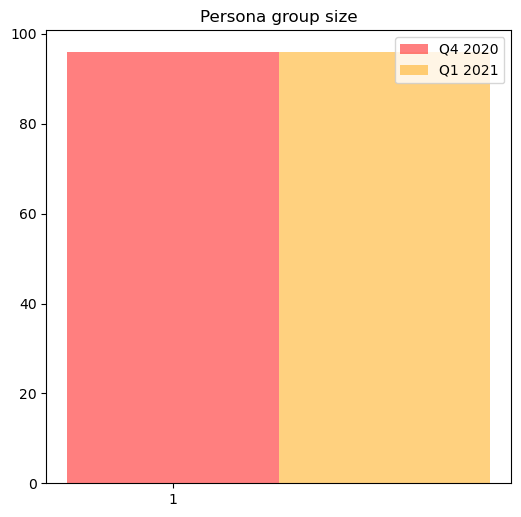

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(6,6), 'figure.dpi':100})

size['Persona'] = size['Persona'].astype(int) + 1
persona1 = size[size['Persona'] == 1]
x1_axis_labels = persona1['Persona'].sort_values().tolist()
y1_axis_values = persona1['Magnitude_Q4'].tolist()
x2_axis_labels = persona1['Persona'].sort_values().tolist()
y2_axis_values = persona1['Magnitude_Q1'].tolist()

y1_pos=np.arange(len(x1_axis_labels))
y2_pos=np.arange(len(x2_axis_labels))

kwargs = dict(alpha=0.5)

plt.bar(y1_pos + 0, y1_axis_values, **kwargs, width=0.15, color = 'red', label='Q4 2020')
plt.bar(y2_pos + 0.15, y2_axis_values, **kwargs, width=0.15, color = 'orange', label='Q1 2021')

plt.xticks(y1_pos, x1_axis_labels)
plt.xticks(y2_pos, x2_axis_labels)

plt.legend(loc='best')
plt.title("Persona group size")
plt.show()


## Visit history

<b style="color: red">This section consists of the visualization of the visit history of persona 1 (in code, the caluclation always started with 0. Thus persona 1 is cluster 0). It's not specified in the variable name, however filtered in the below cell.</b>

In [13]:
dfQ4_ori = pd.read_csv('final-Q4.csv')
dfQ1_ori = pd.read_csv('final-Q1.csv')


dfQ4 = dfQ4_ori[dfQ4_ori['cluster'] == 0]
dfQ1 = dfQ1_ori[dfQ1_ori['new cluster'] == 0]
dfQ4.head()

,Unnamed: 0,userID,companyID,country,activity,event,page,timestamp,hour,day,week,userCountPerCompany,cluster
0,0,34,5,Indonesia,Page,0.0,https://en.wikipedia.org/wiki/Financial_services,2020-10-04 23:02:44,6,0,1,977,0
2,2,195,8,Turkey,Event,1.0,https://en.wikipedia.org/wiki/Bookkeeping,2020-12-31 09:02:33,12,3,14,989,0
4,4,65,42,Turkey,Event,3.0,https://en.wikipedia.org/wiki/Financial_services,2020-12-02 01:32:00,4,2,10,2012,0
8,8,115,32,Indonesia,Page,0.0,https://en.wikipedia.org/wiki/Main_Page,2020-10-13 02:39:42,9,1,3,1962,0
9,9,120,15,Turkey,Event,2.0,https://en.wikipedia.org/wiki/Financial_services,2020-10-19 09:37:45,12,0,4,1960,0


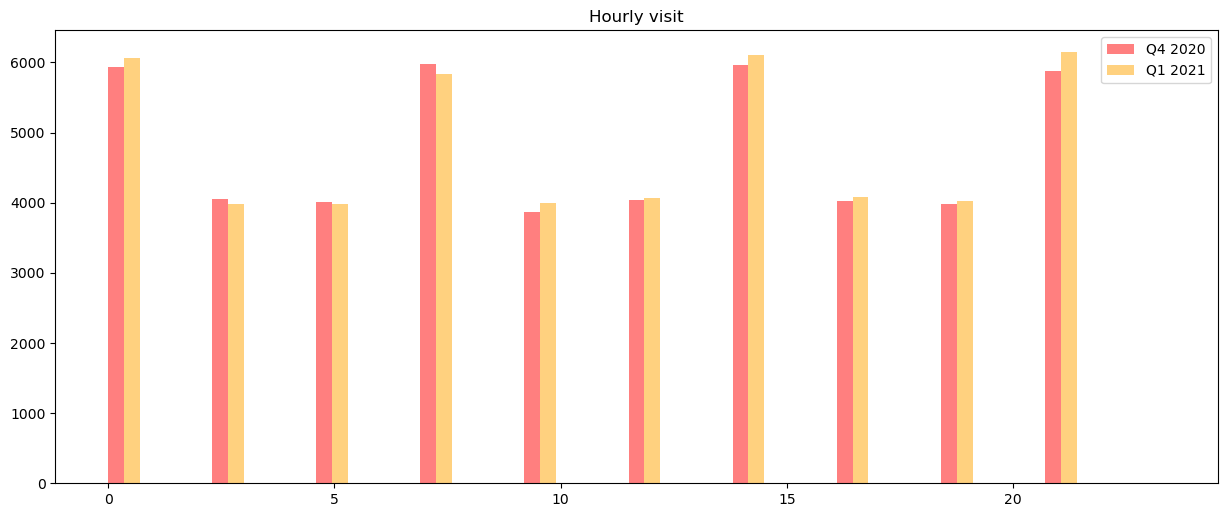

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})

x1 = dfQ4['hour']
x2 = dfQ1['hour']
kwargs = dict(alpha=0.5)

plt.hist(x1, **kwargs, label='Q4 2020', width=0.35, color='red')
plt.hist(x2 + 0.35, **kwargs, label='Q1 2021', width=0.35, color='orange')
plt.gca().set(title='Hourly visit')

plt.legend();

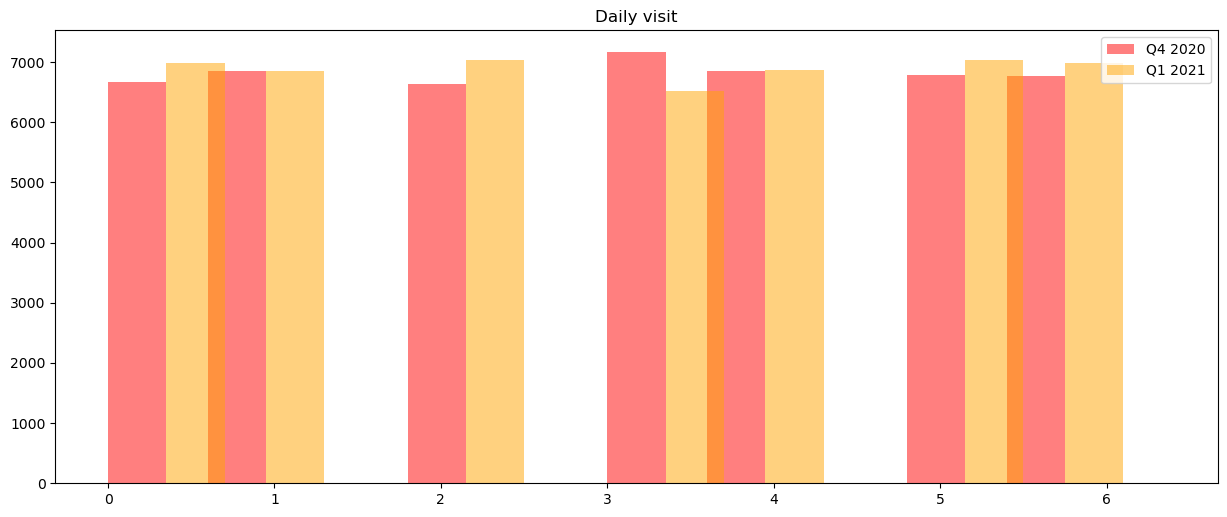

In [15]:
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':100})

x1 = dfQ4['day']
x2 = dfQ1['day']
kwargs = dict(alpha=0.5)

plt.hist(x1, **kwargs, label='Q4 2020', width=0.35, color='red')
plt.hist(x2 + 0.35, **kwargs, label='Q1 2021', width=0.35, color='orange')
plt.gca().set(title='Daily visit')
plt.legend();

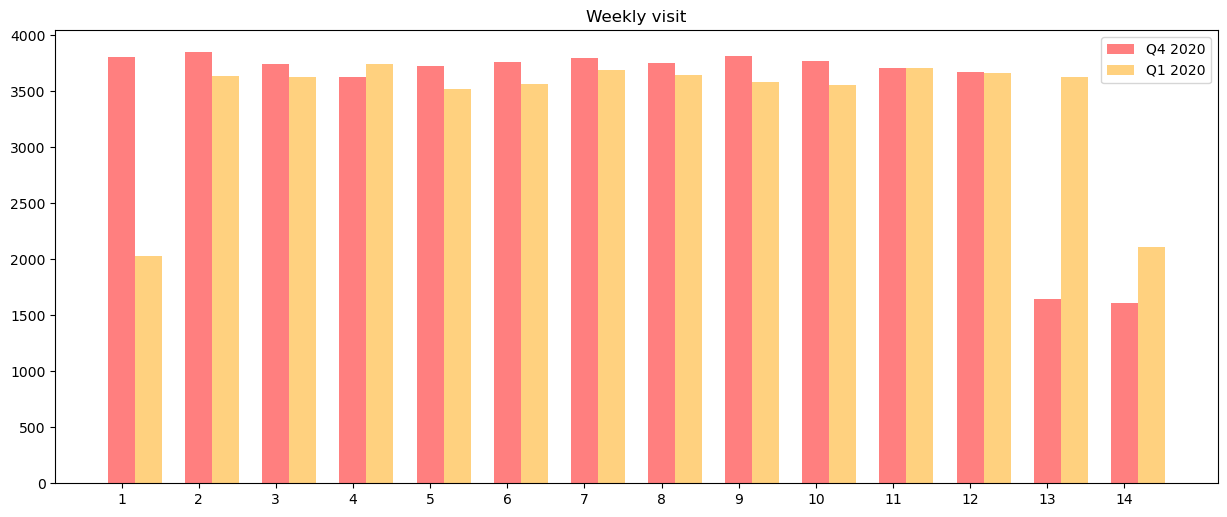

In [16]:
weeklyVisitQ4 = dfQ4[['week']]
weeklyVisitQ4 = weeklyVisitQ4.sort_values(by=['week']).reset_index()
weeklyVisitQ4 = weeklyVisitQ4.reset_index()
weeklyVisitQ4 = weeklyVisitQ4['week'].value_counts().reset_index()
weeklyVisitQ4 = weeklyVisitQ4.sort_values(by=['index'])
weeklyVisitQ4.rename(columns={'index': 'weekNumber', 'week': 'count'}, inplace=True)
weeklyVisitQ4 = weeklyVisitQ4.reset_index()
weeklyVisitQ4['week1'] = weeklyVisitQ4.index + 1

weeklyVisitQ1 = dfQ1[['week']]
weeklyVisitQ1 = weeklyVisitQ1.sort_values(by=['week']).reset_index()
weeklyVisitQ1 = weeklyVisitQ1.reset_index()
weeklyVisitQ1 = weeklyVisitQ1['week'].value_counts().reset_index()
weeklyVisitQ1 = weeklyVisitQ1.sort_values(by=['index'])
weeklyVisitQ1.rename(columns={'index': 'weekNumber', 'week': 'count'}, inplace=True)
weeklyVisitQ1 = weeklyVisitQ1.reset_index()
weeklyVisitQ1['week1'] = weeklyVisitQ1.index + 1
weeklyVisitQ1

x1_axis_labels = weeklyVisitQ1['week1'].tolist()
y1_axis_values = weeklyVisitQ1['count'].tolist()
x2_axis_labels = weeklyVisitQ4['week1'].tolist()
y2_axis_values = weeklyVisitQ4['count'].tolist()

y1_pos=np.arange(len(x1_axis_labels))
y2_pos=np.arange(len(x2_axis_labels))

kwargs = dict(alpha=0.5)

plt.bar(y1_pos + 0, y1_axis_values, **kwargs, width=0.35, color = 'red', label='Q4 2020')
plt.bar(y2_pos + 0.35, y2_axis_values, **kwargs, width=0.35, color = 'orange', label='Q1 2020')

plt.xticks(y1_pos, x1_axis_labels)
plt.xticks(y2_pos, x2_axis_labels)

plt.legend(loc='best')
plt.title("Weekly visit")
plt.show()

## Click stream comparison of the two quarters
The below section consists of the table printouts of the clickstreams

In [17]:
clickstream1 = dfPQ1_1.merge(dfPQ4_1, on='concat_ws(> , collect_list(pageActivity))')
clickstream1.rename(columns={
    'concat_ws(> , collect_list(pageActivity))': 'Page & Action',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream1.head(25)

,Page & Action,Q1 2021,Q4 2020
0,Event-https://en.wikipedia.org,1072,1055
1,Event-https://en.wikipedia.org/wiki/Accounting,1013,1025
2,Event-https://en.wikipedia.org/wiki/Financial_technology,1012,1020
3,Page-https://en.wikipedia.org/wiki/Bookkeeping,1001,1028
4,Page-https://en.wikipedia.org/wiki/Main_Page,988,1051
5,Event-https://en.wikipedia.org/wiki/Main_Page,985,1046
6,Event-https://en.wikipedia.org/wiki/Financial_services,984,973
7,Page-https://en.wikipedia.org/wiki/Accounting,973,1040
8,Event-https://en.wikipedia.org/wiki/Bookkeeping,971,1050
9,Page-https://en.wikipedia.org/wiki/Financial_technology,970,1055


In [18]:
clickstream2 = dfPQ1_1a.merge(dfPQ4_1a, on='concat_ws(> , collect_list(page))')
clickstream2.rename(columns={
    'concat_ws(> , collect_list(page))': 'Page',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream2.head(25)

,Page,Q1 2021,Q4 2020
0,https://en.wikipedia.org,2016,2084
1,https://en.wikipedia.org/wiki/Accounting,1986,2065
2,https://en.wikipedia.org/wiki/Financial_technology,1982,2075
3,https://en.wikipedia.org/wiki/Main_Page,1973,2097
4,https://en.wikipedia.org/wiki/Bookkeeping,1972,2078
5,https://en.wikipedia.org/wiki/Financial_services,1918,2018
6,https://en.wikipedia.org/wiki/Financial_services> https://en.wikipedia.org/wiki/Financial_services,205,159
7,https://en.wikipedia.org/wiki/Bookkeeping> https://en.wikipedia.org,197,169
8,https://en.wikipedia.org> https://en.wikipedia.org/wiki/Financial_services,192,190
9,https://en.wikipedia.org/wiki/Financial_services> https://en.wikipedia.org/wiki/Bookkeeping,189,155


In [19]:
clickstream3 = dfPQ1_1b.merge(dfPQ4_1b, on='concat_ws(> , collect_list(activity))')
clickstream3.rename(columns={
    'concat_ws(> , collect_list(activity))': 'Action',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream3.head(25)

,Action,Q1 2021,Q4 2020
0,Event,6037,6169
1,Page,5810,6248
2,Event> Event,1561,1495
3,Page> Page,1548,1550
4,Event> Page,1533,1447
5,Page> Event,1471,1539
6,Page> Event> Page,396,390
7,Page> Event> Event,391,377
8,Page> Page> Event,387,404
9,Event> Page> Page,381,410


In [20]:
clickstream4 = dfPQ1_1c.merge(dfPQ4_1c, on='page')
clickstream4.rename(columns={
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
pd.set_option('display.max_colwidth', -1)
clickstream4

,page,Q1 2021,Q4 2020
0,https://en.wikipedia.org/wiki/Financial_services,4085,3832
1,https://en.wikipedia.org,4094,4020
2,https://en.wikipedia.org/wiki/Main_Page,3970,3976
3,https://en.wikipedia.org/wiki/Accounting,4063,4020
4,https://en.wikipedia.org/wiki/Financial_technology,3954,3884
5,https://en.wikipedia.org/wiki/Bookkeeping,4046,3949


In [21]:
clickstream5 = dfPQ1_1d.merge(dfPQ4_1d, on='concat_ws(> , collect_list(actDetail))')
clickstream5.rename(columns={
    'concat_ws(> , collect_list(actDetail))': 'Page & Action details',
    'count_x': 'Q1 2021',
    'count_y': 'Q4 2020'
}, inplace=True)
clickstream5['Page & Action details'] = clickstream5['Page & Action details'].str.replace('-0.0','')
clickstream5['Page & Action details'] = clickstream5['Page & Action details'].str.replace('1.0','Upload invoice')
clickstream5['Page & Action details'] = clickstream5['Page & Action details'].str.replace('2.0','Download invoice')
clickstream5['Page & Action details'] = clickstream5['Page & Action details'].str.replace('3.0','Share invoice')
pd.set_option('display.max_colwidth', -1)
clickstream5.head(15)

,Page & Action details,Q1 2021,Q4 2020
0,Page-https://en.wikipedia.org/wiki/Bookkeeping,1001,1028
1,Page-https://en.wikipedia.org/wiki/Main_Page,988,1051
2,Page-https://en.wikipedia.org/wiki/Accounting,973,1040
3,Page-https://en.wikipedia.org/wiki/Financial_technology,970,1055
4,Page-https://en.wikipedia.org,944,1029
5,Page-https://en.wikipedia.org/wiki/Financial_services,934,1045
6,Event-https://en.wikipedia.org-Download invoice,378,357
7,Event-https://en.wikipedia.org/wiki/Financial_technology-Upload invoice,366,365
8,Event-https://en.wikipedia.org-Share invoice,351,346
9,Event-https://en.wikipedia.org/wiki/Accounting-Share invoice,346,325


In the below, additional information about user activity count is presented in a table. 0 means not applicable, 1 means upload invoice, 2 means download invoice, and 3 means share invoice.

In [22]:
getAction = dfQ1
getAction['activity'] = getAction['activity'].replace({0: 'Page', 1: 'Event'})
getAction['activity'].value_counts()

Event    24212
Page     24070
Name: activity, dtype: int64

In [23]:
action1 = getAction[getAction['new cluster'] == 0]
action1 = action1['event'].value_counts()
action1 = action1.reset_index()
action1

,index,event
0,0.0,24070
1,1.0,8119
2,3.0,8107
3,2.0,7986


## User movement
In this section, we show the amount of user moving from one persona in Q4 to another in Q1. For the purpose of the presentation, the moving user calculation is specifically done for Q1. Current result shows no user has been moved to another persona.

In [27]:
# movingUser = csQ1_pd[csQ1_pd['change'] != '0']
movingUser = csQ1_pd[['cluster', 'new cluster']].value_counts()
movingUser = pd.DataFrame(movingUser)
movingUser = movingUser.reset_index()
movingUser = movingUser.rename(columns={0: 'count','cluster': 'original persona', 'new cluster': 'current persona'})
movingUser = movingUser.sort_values(by='original persona')
movingUser

,original persona,current persona,count
0,0,0,48282
2,1,1,16046
3,2,2,5045
1,3,3,31728


## All cluster in Q1 (overlay)
The below section show the position of each user activity in all personas in 3D plot with events, daily visit and user count per company as axes.

In [29]:
dfQ1['event'] = dfQ1['event'].astype(float)
dfQ1['event'] = dfQ1['event'].astype(int)
dfQ1['userCountPerCompany'] = dfQ1['userCountPerCompany'].astype(int)
dfQ1.head()

,Unnamed: 0,Unnamed: 0.1,userID,companyID,country,activity,event,timestamp,page,hour,day,week,userCountPerCompany,cluster,predictions,Most common predictions,new cluster
2,2,2,195,8,Turkey,Page,0,2021-02-11 12:56:44,https://en.wikipedia.org/wiki/Financial_services,15,3,6,1027,0,0,0,0
4,4,4,84,17,Indonesia,Event,2,2021-01-05 13:55:09,https://en.wikipedia.org/wiki/Accounting,20,1,1,1487,0,0,0,0
5,5,5,15,43,Indonesia,Page,0,2021-03-09 01:41:07,https://en.wikipedia.org/wiki/Bookkeeping,8,1,10,1937,0,0,0,0
6,6,6,137,16,Turkey,Page,0,2021-03-09 10:13:22,https://en.wikipedia.org/wiki/Financial_technology,13,1,10,1965,0,0,0,0
7,7,7,193,29,Turkey,Event,1,2021-01-09 11:28:40,https://en.wikipedia.org/wiki/Main_Page,14,5,1,1037,0,0,0,0


In [30]:
def userCountCat(x):
    if x <= 1000:
        return '1 - 1000'
    elif x <= 2000 and x > 1000:
        return '1001 - 2000'
    elif x <= 3000 and x > 2000:
        return '2001 - 3000'
    elif x <= 4000 and x > 3000:
        return '3001 - 4000'
    elif x <= 5000 and x > 4000:
        return '4001 - 5000'
    elif x <= 6000 and x > 5000:
        return '5001 - 6000'
    elif x <= 7000 and x > 6000:
        return '6001 - 7000'

for col in dfQ1.columns:
    dfQ1['userCountCat'] = dfQ1['userCountPerCompany'].apply(lambda x: userCountCat(x))

dfQ1['userCountCat'].value_counts()

1001 - 2000    28525
2001 - 3000    16344
1 - 1000       3413 
Name: userCountCat, dtype: int64

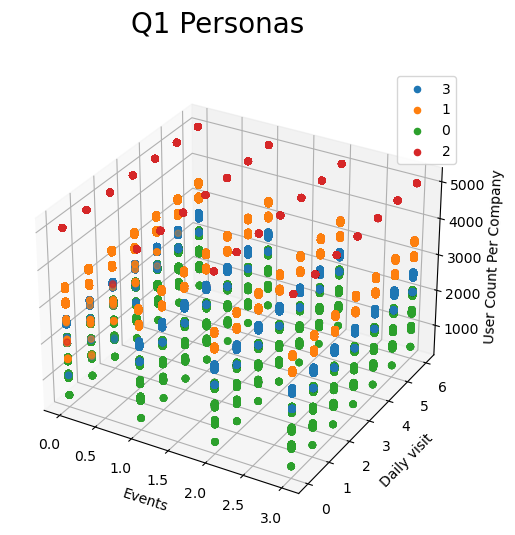

In [31]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for s in dfQ1_ori.predictions.unique():
    ax.scatter(dfQ1_ori.event[dfQ1_ori.predictions==s],dfQ1_ori.day[dfQ1_ori.predictions==s],dfQ1_ori.userCountPerCompany[dfQ1_ori.predictions==s],label=s)
    
fig.suptitle('Q1 Personas', fontsize=20)
ax.set_xlabel('Events')
ax.set_ylabel('Daily visit')
ax.set_zlabel('User Count Per Company')
    
ax.legend()

## Highlights
From all of the above calculations, the below section covers the creation of the highlight section.

First, the change of amount is calculated.

In [32]:
changeInAmount = (persona1['Magnitude_Q4'].values[0] - persona1['Magnitude_Q1'].values[0])
changeInPercentage = (persona1['MagnitudeInPercentage_Q4'].values[0] - persona1['MagnitudeInPercentage_Q1'].values[0])

changeInAmount = changeInAmount.astype(str)
changeInPercentage = changeInPercentage.astype(int)


Then, the starting point of the user journey is studied. Only the two main pages were included in the study though.
<br><Br>
    <b>Important</b>: The amount of columns on line one key below are dependent on the dataset and need to be manually updated. When an error occured, try to add or remove columns. When adding the columns, add the numbers accordingly ('five', 'six', etc.)

In [33]:
clickstream2[['One','Two', 'Three', 'Four', 'Five', 'Six']] = clickstream2.Page.str.split(">",expand=True,)
start_main = clickstream2[clickstream2['One'] == 'https://en.wikipedia.org/wiki/Main_Page']
start_home = clickstream2[clickstream2['One'] == 'https://en.wikipedia.org']

start_main_index = start_main.index
start_main_index = len(start_main_index)
start_home_index = start_home.index
start_home_index = len(start_home_index)

start_home_differences = (start_home['Q1 2021'].sum()) - (start_home['Q4 2020'].sum())
start_main_differences = (start_main['Q1 2021'].sum()) - (start_main['Q4 2020'].sum())

Then, the list of pages of which activity happened the most is calculated.

In [34]:
activity_sorted = clickstream4.sort_values('Q1 2021')
activity_sorted = activity_sorted['page'].tolist()
activity_sorted

['https://en.wikipedia.org/wiki/Financial_technology',
 'https://en.wikipedia.org/wiki/Main_Page',
 'https://en.wikipedia.org/wiki/Bookkeeping',
 'https://en.wikipedia.org/wiki/Accounting',
 'https://en.wikipedia.org/wiki/Financial_services',
 'https://en.wikipedia.org']

Lastly, put the 3 highest information of the visit history on list to be presented in the highlights.

In [35]:
hour_q1 = dfQ1['hour'].value_counts()
hour_q1 = pd.DataFrame(hour_q1)
hour_q1 = hour_q1.sort_values('hour', ascending=False).reset_index()
hour_q1 = hour_q1.iloc[:3]
hour_q1 = (hour_q1['index']).tolist()

day_q1 = dfQ1['day'].value_counts()
day_q1 = pd.DataFrame(day_q1)
day_q1 = day_q1.sort_values('day', ascending=False).reset_index()
day_q1 = day_q1.iloc[:3]
day_q1 = (day_q1['index'])
day_q1.rename({0: 'Sunday', 
               1: 'Monday',
               2: 'Tuesday', 
               3: 'Wednesday',
               4: 'Thrusday', 
               5: 'Friday',
               6: 'Saturday'}, inplace=True)
day_q1 = pd.DataFrame(day_q1)
day_q1 = day_q1.reset_index()
day_q1 = day_q1['level_0'].tolist()

week_q1 = weeklyVisitQ1.sort_values('count', ascending=False)
week_q1 = week_q1.iloc[:3]
week_q1 = (week_q1['week1']).tolist()

The below are the story line created for the highlight, inserted with variables from the calculation above.

In [36]:
print('In the new quarter, the persona size has a change in the amount of', changeInAmount, ' and thus make the persona size change ', changeInPercentage, '%.')
print(' ')
print('As Wikipedia has both main page and homepage. Understanding the start of user journey is important.')
print('This quarter', start_home_index, ' amount of the users started their jouney through the homepage. A change of ', start_home_differences, ' from last quarter.')
print('Further', start_main_index, ' amount of the users started their jouney through the main page. A change of ', start_main_differences, ' from last quarter.')
print(' ')
print('The below are sorted list of the pages with the most activities (highest - lowest):')
print(activity_sorted)
print(' ')
print('Lastly, this quarter, the users mostly visit the platform on ', day_q1, 'at these times:', hour_q1)
print('The users also mostly visit the platform at these weeks:', week_q1)



In the new quarter, the persona size has a change in the amount of 0  and thus make the persona size change  0 %.
 
As Wikipedia has both main page and homepage. Understanding the start of user journey is important.
This quarter 160  amount of the users started their jouney through the homepage. A change of  -75  from last quarter.
Further 142  amount of the users started their jouney through the main page. A change of  -59  from last quarter.
 
The below are sorted list of the pages with the most activities (highest - lowest):
['https://en.wikipedia.org/wiki/Financial_technology', 'https://en.wikipedia.org/wiki/Main_Page', 'https://en.wikipedia.org/wiki/Bookkeeping', 'https://en.wikipedia.org/wiki/Accounting', 'https://en.wikipedia.org/wiki/Financial_services', 'https://en.wikipedia.org']
 
Lastly, this quarter, the users mostly visit the platform on  ['Sunday', 'Monday', 'Tuesday'] at these times: [21, 20, 13]
The users also mostly visit the platform at these weeks: [2, 9, 1]
